In [63]:
get_ipython().magic(u'matplotlib notebook')

import scipy.io as spio
from scipy.signal import firwin,freqz,filtfilt
from scipy.fftpack import fft,fftfreq
import numpy as np
from matplotlib import pyplot as plt
import math
import matplotlib as mpl
import csv
from pykalman import KalmanFilter
from jupyterthemes import jtplot
jtplot.style()
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
mpl.rcParams['agg.path.chunksize'] = 10000

# Gesture Recognition Of An Arm Using A 9-DOF Inertial Measurement Unit
<br>
<center>Shanmugam MPl</center>

 <center>![](images/orthotic1.png)</center> 
 

 <center>![](images/orthotic2.png)</center> 
 

In [197]:
n_timesteps = 150
t = np.linspace(0, 1, n_timesteps)

data = []
dataOI = []
dataUD = []

for i in range (1,81):
    data.append(np.genfromtxt('OI/OI'+str(i)+'.csv', dtype=float, delimiter=','))
    dataOI.append(np.genfromtxt('OI/OI'+str(i)+'.csv', dtype=float, delimiter=','))

for i in range (1,81):
    data.append(np.genfromtxt('UD/UD'+str(i)+'.csv', dtype=float, delimiter=','))
    dataUD.append(np.genfromtxt('UD/UD'+str(i)+'.csv', dtype=float, delimiter=','))


sensors = {'Accelx':0,'Accely':1,'Accelz':2,'Magnetx':3,'Magnety':4,'Magnetz':5,'Gyrox':6,'Gyroy':7,'Gyroz':8}
sensorLabel = ['Accelx, G','Accely, G','Accelz, G','Magnetx, Gauss','Magnety, Gauss','Magnetz, Gauss','Gyrox, deg/s','Gyroy, deg/s','Gyroz, deg/s']

sensorsAll = sensors
sensorAllLabel=sensorLabel
dataAll = data[0]
data = np.array(data)
dataOI = np.array(dataOI)
dataUD = np.array(dataUD)
dataOI = dataOI.astype(float)
dataUD = dataUD.astype(float)

In [226]:
dataOITraining = dataOI[0:(len(dataOI)/2)-1]
dataUDTraining = dataUD[0:(len(dataUD)/2)-1]
dataOITest = dataOI[(len(dataOI)/2):-1]
dataUDTest = dataUD[(len(dataUD)/2):-1]

X = np.concatenate((dataOITraining,dataUDTraining),axis=0) #putting them on top of each other
X = X.reshape(len(X),-1)

TestData = np.concatenate((dataOITest,dataUDTest),axis=0) #putting them on top of each other
TestData = TestData.reshape(len(TestData),-1)

OI = np.zeros(dataOITraining.shape[0])
UD = np.ones(dataUDTraining.shape[0])
y = np.concatenate((OI,UD),axis=0)
Testy= np.concatenate((OI,UD),axis=0) #labels are the same for test and training (first bits are OI and rest are UD)


In [199]:
def f(x):
    return x
def pltsensor(f):
    plt.close()
    plt.plot(t, dataAll[:,f]);
    plt.ylabel(sensorAllLabel[f]);
    plt.xlabel('Time, seconds');
    plt.show();

# Pick channels of interest for classification

In [187]:
interact(pltsensor,f=sensorsAll);


interactive(children=(Dropdown(description=u'f', options={'Accelz': 2, 'Accelx': 0, 'Accely': 1, 'Gyroz': 8, 'Gyrox': 6, 'Gyroy': 7, 'Magnety': 4, 'Magnetx': 3, 'Magnetz': 5}, value=2), Output()), _dom_classes=('widget-interact',))

In [200]:
data = np.delete(data,[0,1,2,5,7,9,10,11], 2)
dataOI = np.delete(dataOI,[0,1,2,5,7,9,10,11], 2)
dataUD = np.delete(dataUD,[0,1,2,5,7,9,10,11], 2)
#update labels
sensors = {'Magnetx':0,'Magnety':1,'Gyrox':2,'Gyroz':3}
sensorLabel = ['Magnetx, Gauss','Magnety, Gauss','Gyrox, deg/s','Gyroz, deg/s']

In [220]:
def kalman(x,UD):
    plt.close()
    kf = KalmanFilter(transition_matrices=np.array([[1, 1], [0, 1]]),transition_covariance=0.01 * np.eye(2))
    if(UD==True):
        observations = dataUD[0][:,x]
    if(UD==False):
        observations = dataOI[0][:,x]
    states_pred = kf.em(observations).smooth(observations)[0]
    obs_scatter = plt.scatter(t, observations, marker='x', color='b',
                             label='observations')
    position_line = plt.plot(t, states_pred[:, 0],
                            linestyle='-', marker='o', color='r',
                            label='position est.')
    plt.ylabel(sensorLabel[x])
    plt.xlabel('Time, seconds')
    plt.legend()


# Kalman Filtering
<center>![](images/kalman.jpg)</center>

In [221]:
def g(x, UD):
    return (x, UD)

In [222]:

interact(kalman,x=sensors,UD=True);

interactive(children=(Dropdown(description=u'x', options={'Gyroz': 3, 'Gyrox': 2, 'Magnety': 1, 'Magnetx': 0}, value=3), Checkbox(value=True, description=u'UD'), Output()), _dom_classes=('widget-interact',))

# Principal Component Analysis
## Dimensionality Reduction

In [99]:
# dataflat = data.reshape(len(data),150*data.shape[2])
# dataflat = dataflat.astype(float)

# dataflatmat = np.matrix(dataflat)

#cov = (1.0/(150*data.shape[2]))*(dataflatmat.T*dataflatmat)

dataflat = X.astype(float)

dataflatmat = np.matrix(dataflat)

cov = (1.0/(150*data.shape[2]))*(dataflatmat.T*dataflatmat)

<IPython.core.display.Javascript object>


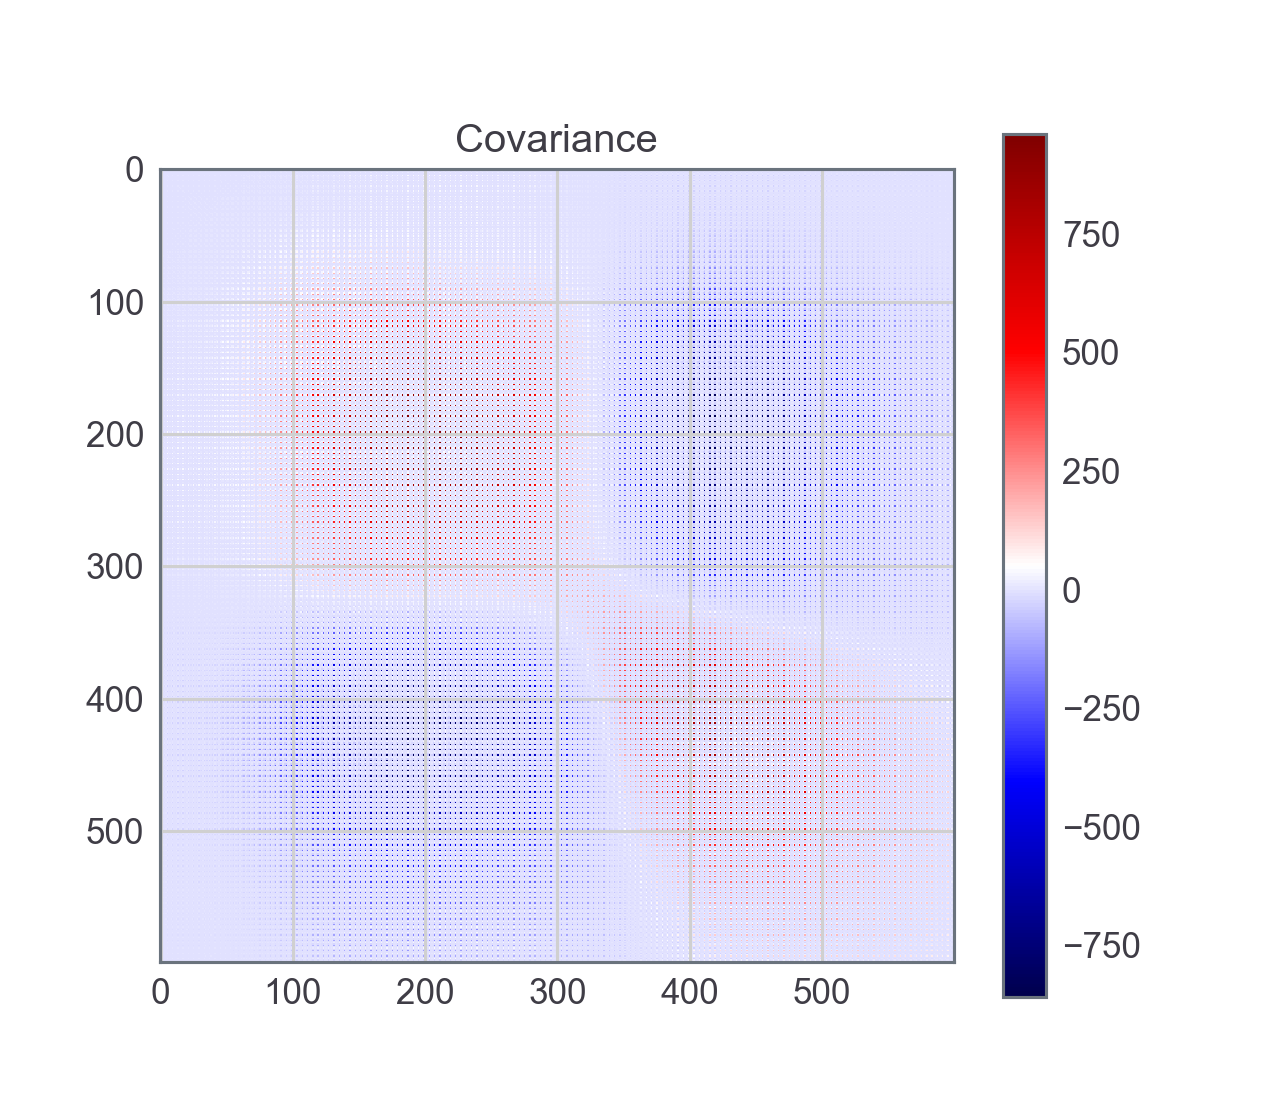

In [100]:
plt.close()
plt.imshow(cov, cmap='seismic', interpolation='nearest');
plt.title('Covariance');
plt.colorbar();

In [101]:
w,v = np.linalg.eig(cov)
sortedw =np.sort(w)
max1 = sortedw[len(sortedw)-1] #eigenvector corresponding to the largest eigenvalue
max2 = sortedw[len(sortedw)-2] #eigenvector corresponding to the second largest eigenvalue

vec1 = (v[:,0])
vec2 = (v[:,1])

<IPython.core.display.Javascript object>


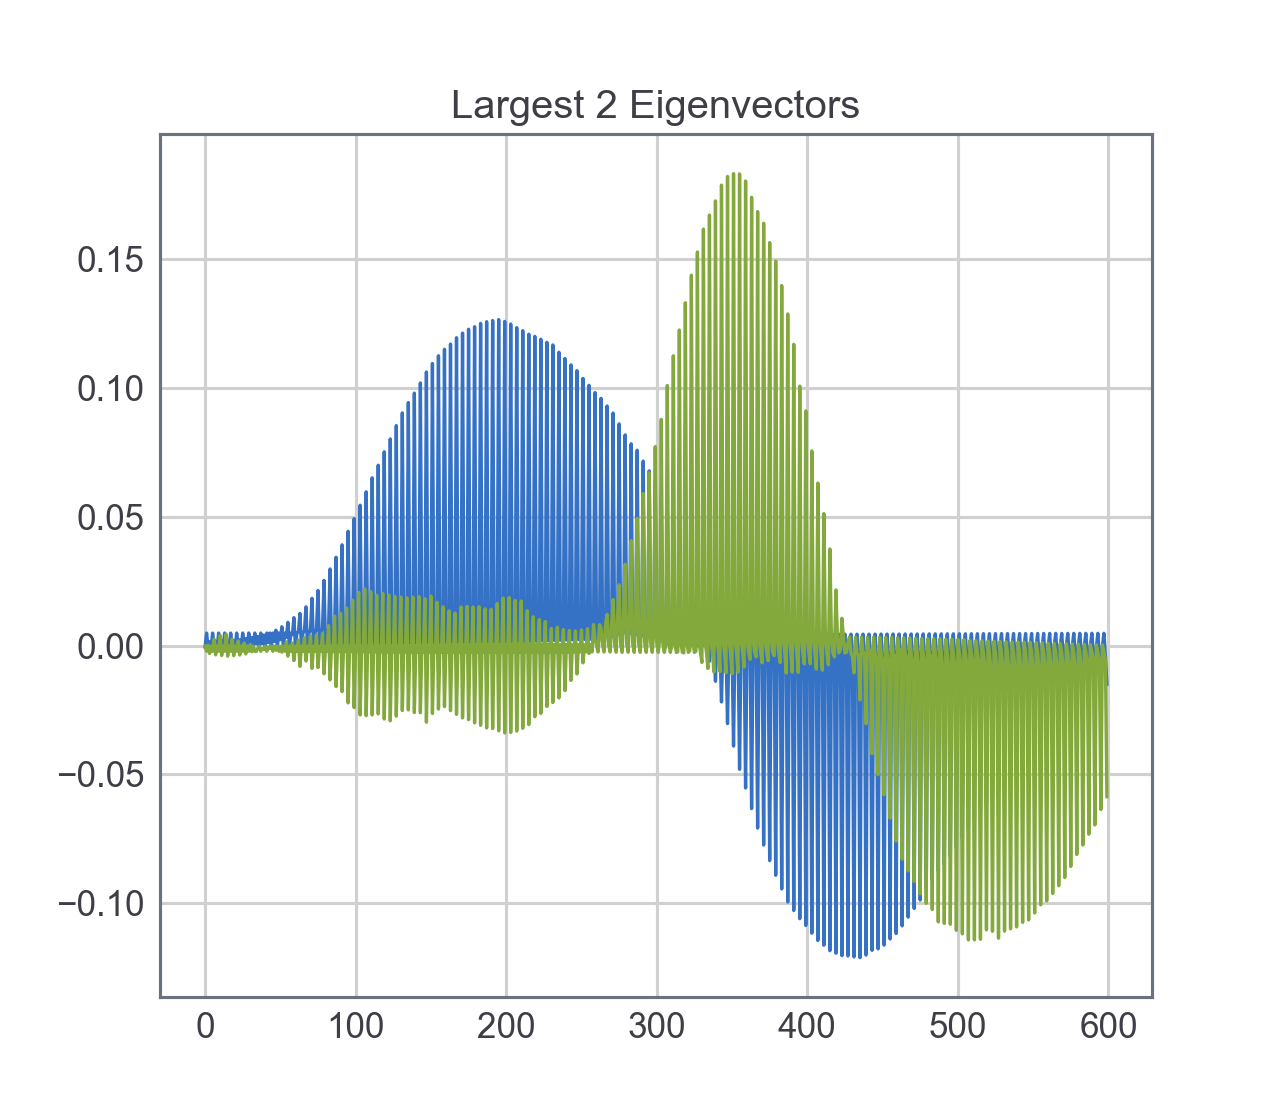

In [102]:
plt.close()
plt.plot(np.arange(len(vec1)),vec1);
plt.plot(np.arange(len(vec2)),vec2);
plt.title('Largest 2 Eigenvectors');

In [227]:
def threshold(f):
    plt.close()
    akOI = (vec1.reshape(-1)) * dataOITraining.reshape(len(dataOITraining),-1).T
    bkOI = (vec2.reshape(-1)) * dataOITraining.reshape(len(dataOITraining),-1).T
    plt.scatter([akOI],[bkOI],color='magenta');
    
    akUD = (vec1.reshape(-1)) * dataUDTraining.reshape(len(dataUDTraining),-1).T
    bkUD = (vec2.reshape(-1)) * dataUDTraining.reshape(len(dataUDTraining),-1).T
    plt.scatter([akUD],[bkUD],color='cyan');
    plt.axvline(f)
    
def showTest(b):
    aktestOI = (vec1.reshape(-1)) * dataOITest.reshape(len(dataOITest),-1).T
    bktestOI = (vec2.reshape(-1)) * dataOITest.reshape(len(dataOITest),-1).T
    plt.scatter([aktestOI],[bktestOI],color='r');
    aktestUD = (vec1.reshape(-1)) * dataUDTest.reshape(len(dataUDTest),-1).T
    bktestUD = (vec2.reshape(-1)) * dataUDTest.reshape(len(dataUDTest),-1).T
    plt.scatter([aktestUD],[bktestUD],color='b');

button = widgets.Button(description = "Plot Test Data")


# Lets Visualize this in 2-D

In [229]:
display(button)
interact(threshold,f=(-1000,10,10));
button.on_click(showTest);

Button(description=u'Plot Test Data', style=ButtonStyle())

interactive(children=(IntSlider(value=-500, description=u'f', max=10, min=-1000, step=10), Output()), _dom_classes=('widget-interact',))

# 97.4% Accuracy

# Machine Learning

In [ ]:
from sklearn import svm
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

# Random Forest Classifier
 <center>![](images/randForest.png)</center>
 https://www.researchgate.net/profile/Erika_Amstalden_van_Hove/publication/228540194/figure/fig1/AS:301839783350274@1448975620988/Figure-1-The-Random-Forest-classifier-is-an-ensemble-of-decision-trees-where-the-single.png

In [163]:
clf = RandomForestClassifier(min_samples_leaf=10)
clf.fit(X, y)
Prediction= clf.predict(TestData)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [180]:
def MLaccuracy():
    falsepos= 0
    accuracy= 1-np.logical_xor(Prediction,y)
    similarsum= np.sum(accuracy)
    similarity_perc= 1.0*similarsum/len(Prediction)
    falsehood= Prediction- y
    falsehood
    for i in xrange(0, len(falsehood)):
        if falsehood[i]>0:
            falsepos=falsepos+1

    display("Accuracy")        
    display(similarity_perc *100)
    display("False Positives")
    display(falsepos/float(len(accuracy)))

In [181]:
MLaccuracy()

'Accuracy'

100.0

'False Positives'

0.0